In [77]:
%load_ext autoreload
%autoreload 2

import numpy as np

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Channel Simulation
here starts the actual channel simulator code.

we will demonstrate the following block diagram


In [78]:
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27, # [sec^2 / km] ->TODO [pico sec / km]
    gamma=0.003, # [km^-1 * W^-1] (1.27)
    t0=125e-12,  # 1/50GHz (2*10^-11)
    z_n=1.e-3, # distance in z axis (set it to 0.5km and change others accordigly)
    # dt=1e-12,
    h=100
)
cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=0.001,
                      t0=125e-12,
                      channel_func=ssf,
                      verbose=False)
cb = ChannelBlocks(cs.verbose)

number of iterations in split step algo: 7


In [79]:
cb.verbose = False
cs.x[0] = cb.generate_message(cs.length_of_msg, cs.sps)
cs.x[1], cs.modem = cb.modulate(cs.x[0], cs.m_qam)
cs.x[2] = cb.over_sample(cs.x[1], cs.over_sampling)
cs.x[3], cs.N_rrc, cs.h_rrc = cb.pulse_shape(cs.x[2], cs.roll_off, cs.over_sampling, cs.Ts)
cs.x[4] = cb.pre_equalize(cs.x[3], cs.normalization_factor, cs.P_0)

cs.N_xi, cs.N_time, cs.tvec, cs.xivec, cs.BW, cs.dt = cb.gen_nft_params(cs.x[4], cs.t0)
cs.channel_func.set_dt(cs.dt)

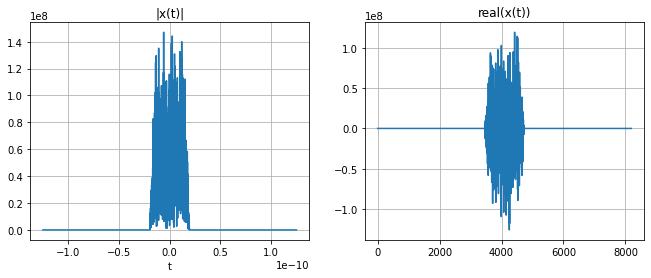

length of INFT(x) = 8192


In [80]:
cb.verbose = True
cs.x[5] = cb.inft(cs.x[4], cs.tvec, cs.xivec)

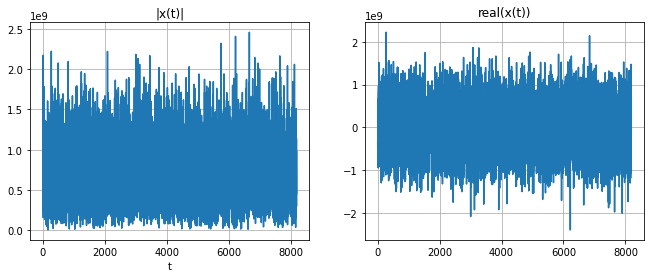

In [81]:
cs.x[6] = cb.channel(cs.x[5], cs.channel_func, cs.P_0)

## 7) NFT

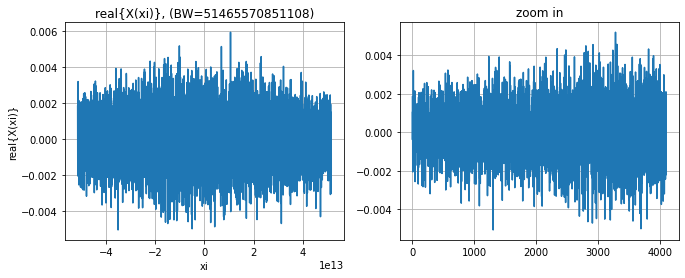

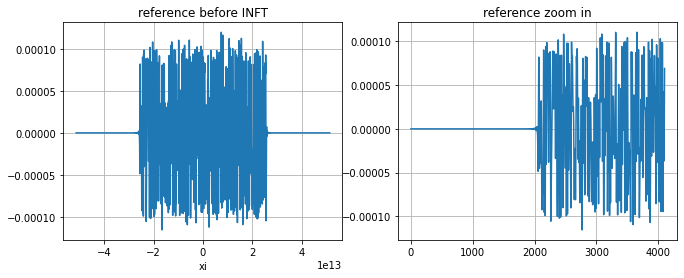

In [82]:
cs.x[7] = cb.nft(cs.x[6], cs.tvec, cs.xivec, cs.BW, cs.N_xi, cs.N_rrc, cs.x[4])

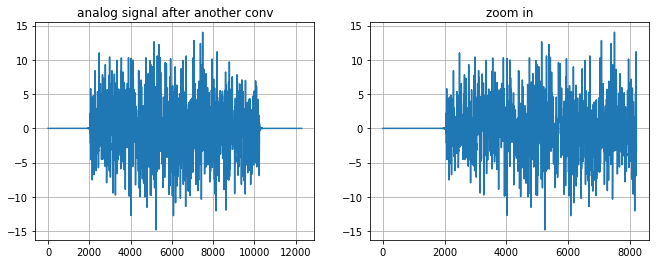

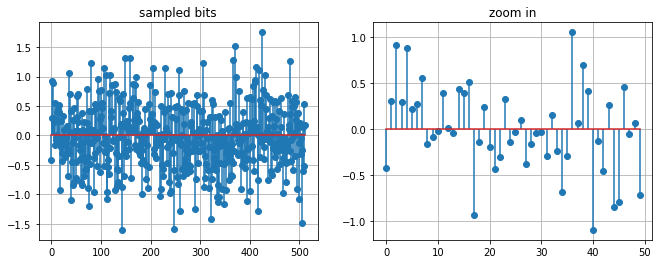

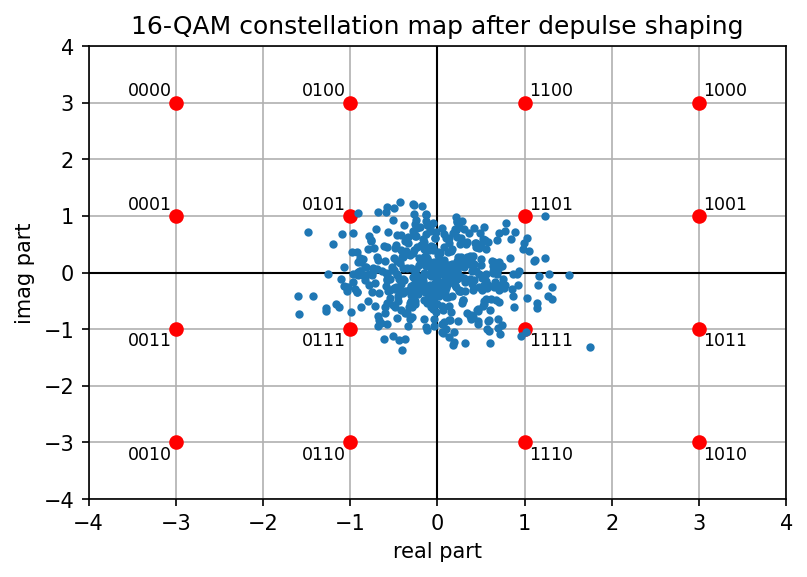

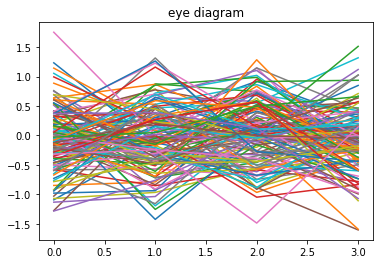

In [83]:
cs.x[8] = cb.equalizer(cs.x[7], cs.normalization_factor)
cs.x[9] = cb.match_filter(cs.x[8], cs.h_rrc, cs.N_rrc, cs.over_sampling, cs.m_qam, cs.sps)
cs.x[10] = cb.demodulate(cs.x[9], cs.modem, cs.length_of_msg)

In [84]:

ber, num_errors = cb.calc_ber(cs.x[0], cs.x[10], cs.length_of_msg, cs.sps)


_______________________________________________
message after channel - len=2048
[[0 1 1 1]
 [1 1 0 1]
 [1 1 1 1]
 ...
 [1 1 1 1]
 [0 1 1 1]
 [1 1 1 1]]
ber = 0.4912109375 = 1006/2048
